In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf
import statsmodels
import moss
%matplotlib inline

In [2]:
home_dir = op.abspath('./')

#plotting settings
fontsize = 18
ticksize = fontsize*.8
sns.set_context('talk')
sns.__version__

'0.13.2'

In [3]:
lags = pd.read_csv(op.join(home_dir,
                             'csvs',
                    'lags_pet_rois.csv'))
lags = lags.rename(columns = {'mask':'roi'})
lags['sub'] = [int(x[2:]) for x in lags['sub']]
lags = lags[lags['sub'] != 216]
lags['lag'] = lags['lag']*1000

In [4]:
behav = pd.read_csv(op.join(home_dir,
                             'csvs',
                            'JOCN_2020_behav_data.csv'))
behav['sub'] = behav['subject']
lags = pd.merge(lags,
        behav,
         'left',
        on = ['sub',
              'drug',
              'session'])

In [5]:
ioannis = pd.read_csv('../ioannis_lags.csv')
print(set(lags['sub']) - set(ioannis['sub']))
lags = lags[lags['sub'] != 220]
lags = lags[lags['sub'] != 395]
len(set(lags['sub']))
len(set(lags['sub']))
nacc_lags = lags[lags['roi']== 'VST']
print(len(set(nacc_lags['sub'])))


{395, 220}
73


In [6]:
tests = [ 'raw_distr_cost', 'raw_sw_cost',
       'raw_distr_acc_cost',
       'raw_sw_acc_cost','transf_nonrep_errs', 'transf_rep_errs']
new_var_labels = []
p_values = {'variable':[],'pvalues':[]}
for test in tests:
    
    if '.' in test:
        
        var = '_'.join(test.split('.'))
        plac_lags[var] = plac_lags[test]
    
    else:
        var = test
        
    
    new_var_labels.append(var)
    for roi in ['VST']:

        roi_lags = lags[lags['roi'] == roi].copy().reset_index()
        
        roi_lags = roi_lags.dropna(subset = var)            
        
        md = smf.mixedlm("lag ~C(drug, Treatment('plac'))*" + var, roi_lags, 
                 groups=roi_lags["sub"]).fit()
        
        p_values['pvalues'].append(md.pvalues[var])
        p_values['variable'].append(var)
        
        print(roi,var,md.summary())
p_values = pd.DataFrame(p_values)

VST raw_distr_cost                                Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               lag        
No. Observations:               219                   Method:                           REML       
No. Groups:                     73                    Scale:                            457034.5230
Min. group size:                3                     Log-Likelihood:                   -1737.7354 
Max. group size:                3                     Converged:                        Yes        
Mean group size:                3.0                                                                
---------------------------------------------------------------------------------------------------
                                                    Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept   

VST transf_rep_errs                                 Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                lag        
No. Observations:                219                    Method:                            REML       
No. Groups:                      73                     Scale:                             380398.6687
Min. group size:                 3                      Log-Likelihood:                    -1706.7678 
Max. group size:                 3                      Converged:                         Yes        
Mean group size:                 3.0                                                                  
------------------------------------------------------------------------------------------------------
                                                     Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------------------

In [7]:
sig, p = statsmodels.stats.multitest.fdrcorrection(p_values['pvalues'])
p_values['p_fdr'] = p
p_values

,variable,pvalues,p_fdr
0,raw_distr_cost,0.592846,0.865182
1,raw_sw_cost,0.636068,0.865182
2,raw_distr_acc_cost,0.852383,0.865182
3,raw_sw_acc_cost,0.675682,0.865182
4,transf_nonrep_errs,0.865182,0.865182
5,transf_rep_errs,0.002684,0.016101


In [8]:
#control for DRD2
var = 'transf_rep_errs'
md = smf.mixedlm("lag ~DRD2*C(drug, Treatment('plac')) + C(drug, Treatment('plac'))*" + var, roi_lags, 
                 groups=roi_lags["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
======================================================================================================
Model:                           MixedLM                Dependent Variable:                lag        
No. Observations:                219                    Method:                            REML       
No. Groups:                      73                     Scale:                             376896.7734
Min. group size:                 3                      Log-Likelihood:                    -1686.3152 
Max. group size:                 3                      Converged:                         Yes        
Mean group size:                 3.0                                                                  
------------------------------------------------------------------------------------------------------
                                                     Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------------------------
Intercept                                            -269.540  171.872 -1.568 0.117  -606.403   67.323
DRD2[T.A1-]                                           284.454  172.716  1.647 0.100   -54.062  622.971
C(drug, Treatment('plac'))[T.brom]                    -35.985  222.851 -0.161 0.872  -472.765  400.794
C(drug, Treatment('plac'))[T.tolc]                    319.086  217.640  1.466 0.143  -107.481  745.654
DRD2[T.A1-]:C(drug, Treatment('plac'))[T.brom]       -420.480  209.346 -2.009 0.045  -830.791  -10.169
DRD2[T.A1-]:C(drug, Treatment('plac'))[T.tolc]       -162.716  203.890 -0.798 0.425  -562.333  236.901
transf_rep_errs                                      1827.534  649.010  2.816 0.005   555.498 3099.569
C(drug, Treatment('plac'))[T.brom]:transf_rep_errs    799.060  874.563  0.914 0.361  -915.051 2513.171
C(drug, Treatment('plac'))[T.tolc]:transf_rep_errs  -1864.682  880.792 -2.117 0.034 -3591.003 -138.362
Group Var                                          163359.492   98.661                                
======================================================================================================

"""

In [9]:
nacc_lags[['rep_errs']].mean()

rep_errs    0.046035
dtype: float64

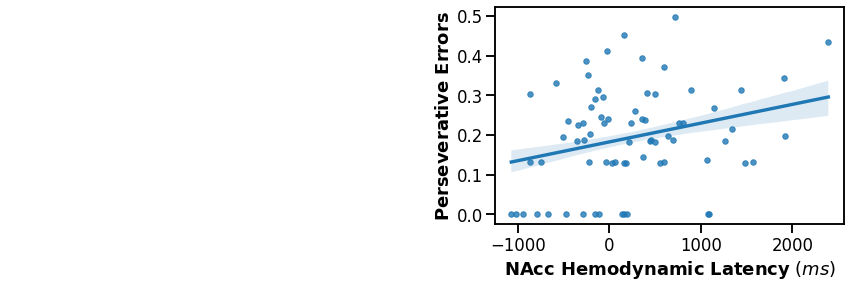

In [10]:
#plotting settings
fontsize = 12
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize


fig = plt.figure(
                figsize=(15,4))
widths = [1,1]

gs = GridSpec(1, 2, 
              figure=fig,
              width_ratios=widths,
              hspace = .4,
              wspace = .4)

ax1 = fig.add_subplot(gs[0:1])
ax2 = fig.add_subplot(gs[1:])


plac = nacc_lags[nacc_lags['drug'] == 'plac']
sns.regplot(x = 'lag',
             y = 'transf_rep_errs',
            scatter_kws={'s':30,
                         'alpha':.8,
                        'color':sns.color_palette()[0]},
            color = sns.color_palette()[0],
              ci = 68,
            ax = ax2,
             data=plac)

ax2.set(xlabel = '$\\bf{NAcc\ Hemodynamic\ Latency}$ $\it{(ms)}$',
        ylabel = '$\\bf{Perseverative\ Errors}$')

ax1.axis('off')
plt.savefig('../figs/paper/behav_correlation.png',
                            bbox_inches = 'tight',
            dpi = 300)